# Image Classification Test Model

#### Project Url: https://github.com/akshath/image_classification_kit_keras

In [ ]:
#---- Install stuff -------
#!pip install --upgrade pip

#!pip install opencv-python
#!pip install tensorflow
#!pip install numpy==1.19.5

#!pip install Pillow
#!pip install playsound
#!pip install gTTS
#!pip install pyobjc

#!pip install matplotlib
#!pip install pandas
#!pip install seaborn

#!pip install PyYAML

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import datetime
import random
from glob import glob
import os

In [3]:
import cv2
from PIL import Image

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model

In [5]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
#print system info
import sys
print('Python: ',sys.version)

Python:  3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]


In [7]:
#print tensor and keras version
print('keras: ', keras.__version__)
print('tensorflow: ', tf.__version__)
import numpy
print('numpy: ', numpy.version.version)

keras:  2.6.0
tensorflow:  2.6.0
numpy:  1.19.5


## Functions

In [8]:
import pycode.FileIOUtil
import pycode.TTSUtil
from pycode.ImageClassificationCfg import ImageClassificationCfg
from pycode.LoadAndTestCNNUtil import LoadAndTestCNNUtil

# Read Cfg

In [9]:
cfg_file = './project/flowers-recognition/cfg.yml'
#cfg_file = './project/work_pose/cfg.yml'
#cfg_file = './project/home_presence/cfg.yml'

cfg_file = ImageClassificationCfg(cfg_file)
cfg_file.load()

In [10]:
cfg_file.log_info()

project_name:  flowers-recognition
--------------------
project_parent_dir:  ./project/
project_data_dir:  ./project/flowers-recognition/data/
temp_dir:  ./temp/
file_ext:  *.jpg
--------------------
reduce_image_wh_by:  3
crop_image_from_left:  0.0
crop_image_from_right:  0.0
--------------------
project_dir:  ./project/flowers-recognition/
project_temp_dir: ./temp/flowers-recognition/
loc_unknown: ./temp/flowers-recognition/non-labeled/
--------------------
labels_from_dir:  False
label count:  5
labels: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [11]:
def get_capture_dim(src_video):
    cap = None
    try:
        cap = cv2.VideoCapture(src_video)
        if(cap.isOpened()):
            ret, frame = cap.read()
            return frame.shape
        else:
            return 0,0
    finally:
        if cap!=None:
            cap.release()
        cv2.destroyAllWindows()

In [12]:
#org shape 1080, 1920
capture_dim = get_capture_dim(cfg_file.cfg['src_video'])
print('org dim: ',capture_dim)

img_h = capture_dim[0]
img_w = capture_dim[1]

img_h = img_h//cfg_file.cfg['reduce_image_wh_by']
img_w = img_w//cfg_file.cfg['reduce_image_wh_by']

print('new dim h:',img_h)
print('new dim w:',img_w)

org dim:  (480, 640, 3)
new dim h: 160
new dim w: 213


In [13]:
def plot_image(images, captions=None, cmap=None):    
    if captions!=None:
        print(captions)
    
    if len(images) > 1:
        f, axes = plt.subplots(1, len(images), sharey=True, figsize=(4,4))
        f.set_figwidth(15)
        for ax,image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        plt.figure(figsize=(4,4))
        plt.imshow(images[0])
    plt.show()

In [14]:
def get_file_name():
    return 'img_'+datetime.now().strftime("%Y%m%d%H%M%S")
#get_file_name()

In [15]:
def capture_frames(cfg_file, crop=True, count=1, delay_sec=60, save=True):
    cap = None
    if img_h==0 or img_w==0:
        raise Exception('img_h or img_w can not be 0')
    try:
        cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
        #cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        
        if(cap.isOpened()):
            for i in range(0, count):
                ret, frame = cap.read()
                if not ret:
                    print("failed to grab frame ")
                    #raise Exception("failed to grab frame ")
                    return None, None

                #print('org shape: ',frame.shape)
                frame = cv2.resize(frame, (img_w,img_h), 
                                   interpolation = cv2.INTER_AREA)

                if crop:
                    if cfg_file.cfg['crop_image_from_left']>0:
                        new_wl = int(img_w*cfg_file.cfg['crop_image_from_left'])
                    else:
                        new_wl = 0
                        
                    if cfg_file.cfg['crop_image_from_right']>0:
                        #crop 70% on width from right
                        new_wr = int(img_w*cfg_file.cfg['crop_image_from_right'])
                    else:
                        new_wr = img_w                    
                        
                    frame = frame[0:img_h,new_wl:new_wr]

                if save:
                    img_name = cfg_file.loc_unknown+"frame_{0}.{1}".format(get_file_name(), cfg_file.cfg['file_ext'][2:])
                    cv2.imwrite(img_name, frame)
                else:
                    img_name = None

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                if count>1 and save:
                    print('file saved: ',img_name)
                    
                if (i+1)!=count:
                    #close and re-open else we will get old frame
                    if cap != None:
                        cap.release()
                    #it take about 2 sec to open cam again
                    if delay_sec>0:
                        time.sleep(delay_sec-2) 
                    cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
                    if(cap.isOpened()==False):
                        print('Could not open camera!')
                        break            
            return frame, img_name
        else:
            print('Could not open camera!')
            return None, None
    finally:
        if cap != None:
            cap.release()
        cv2.destroyAllWindows()

# Load Model

In [16]:
cnn = LoadAndTestCNNUtil(cfg_file)
cnn.debug = True
cnn.load()

Loading model file:  ./project/flowers-recognition//flowers_recognition_model.h5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
_______________________________________

# Load Test Image

In [17]:
print('project_dir: ',cfg_file.project_dir)

project_dir:  ./project/flowers-recognition/


In [18]:
all_images = glob(cfg_file.project_dir+'*/'+cfg_file.cfg['file_ext'])
print('all img count: ',len(all_images))

all img count:  0


file:  ./temp/flowers-recognition/non-labeled/frame_img_20211012145422.jpg


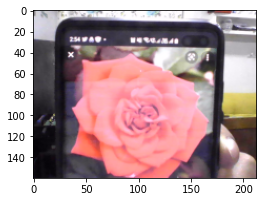

type: <class 'numpy.ndarray'>
shape: (224, 224, 3)
-
Predictions: [[0.08097004 0.00996105 0.84937996 0.02131285 0.0383761 ]]
Score: tf.Tensor([0.16699573 0.15554878 0.36009872 0.15732458 0.1600321 ], shape=(5,), dtype=float32)
-
Class: rose [ 36.01 %]
-------------------------
   ClassName   Score
2       rose  36.010
0      daisy  16.700
4      tulip  16.003
3  sunflower  15.732
1  dandelion  15.555
-


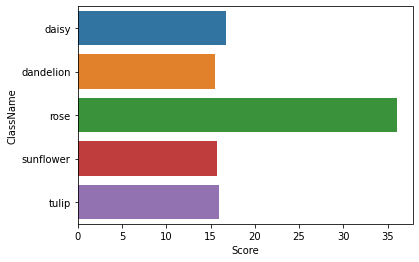

In [21]:
frame = None
file = None

#file = random.choice(all_images)
frame, file = capture_frames(cfg_file=cfg_file,crop=True, count=1, delay_sec=0, save=True)
#file = './project/home_presence/no-one/frame_img_20210713121302.png'

print('file: ',file)
if frame is None:
    frame = Image.open(file)

plot_image([frame])

(img_class, model_acc) = cnn.predict(file)

In [22]:
#delete temp file
if file.startswith(cfg_file.loc_unknown):    
    if os.path.isfile(file):
        print('Deleted temp file')
        os.remove(file)
    else:
        #no file to delete
        pass

Deleted temp file
